In [2]:
from pinky_lcd.pinky_lcd import LCD
from pinkylib import LED, Camera, Motor
from PIL import Image, ImageSequence
from IPython.display import display
import time, io, base64, json
from openai import OpenAI

In [3]:
led = LED()
lcd = LCD()
motor = Motor(); motor.enable_motor()

모터 #1를 성공적으로 '속도 제어 모드'로 설정했습니다.
모터 #2를 성공적으로 '속도 제어 모드'로 설정했습니다.


In [ ]:
EMOTIONS = ['angry','basic','bored','fun','happy','hello','interest','sad']

In [7]:
RED=(255,0,0); ORANGE=(255,127,0); YELLOW=(255,255,0)
GREEN=(0,255,0); BLUE=(0,0,255); INDIGO=(75,0,130)
VIOLET=(148,0,211); WHITE=(255,255,255)

RAINBOW = [RED,ORANGE,YELLOW,GREEN,BLUE,INDIGO,VIOLET]

In [8]:
def play_rainbow_once(dt=0.1):
    for c in RAINBOW:
        led.fill(c); time.sleep(dt)

In [9]:
def play_led_emotion(e):
    if e=="angry":   led.fill(RED)
    elif e=="happy": led.fill(YELLOW)
    elif e=="fun":   play_rainbow_once(0.08)
    elif e=="sad":   led.fill(BLUE)
    elif e=="bored": led.fill(INDIGO)
    elif e=="interest": led.fill(GREEN)
    elif e=="hello":
        led.fill(WHITE); time.sleep(0.2)
        led.fill((0,0,0)); time.sleep(0.1); led.fill(WHITE)
    else: led.fill(WHITE)

In [12]:
play_led_emotion("fun")

In [13]:
def play_emotion(emotion):
    emotion_folder_path = '/home/pinky/pinky_pro/src/pinky_pro/pinky_emotion/emotion/'
    emotion_path = f"{emotion_folder_path}/{emotion}.gif"
    gif = Image.open(emotion_path)
    
    n = 0
    for frame in ImageSequence.Iterator(gif):
        lcd.img_show(frame)
        n += 1
        if n > 20:
            break
        
    print("End Emotion")

In [19]:
def motor_wiggle_lr(c=3, sp=20, dt=0.3):
    for _ in range(c):
        motor.move(sp,-sp); time.sleep(dt)
        motor.move(-sp,sp); time.sleep(dt)
    motor.stop()

In [31]:
def motor_wiggle_fb(c=2, sp=5, dt=0.1):
    for _ in range(c):
        motor.move(sp,sp); time.sleep(dt)
        motor.move(-sp,-sp); time.sleep(dt)
    motor.stop()

In [32]:
def motor_nod_forward(sp=10, dt=0.1):
    motor.move(sp,sp); time.sleep(dt); motor.stop()

In [33]:
def play_motor_emotion(e):
    if e in ["happy","fun","hello"]:
        motor_wiggle_lr()
    elif e=="sad":
        motor_wiggle_fb()
    elif e=="angry":
        motor_wiggle_fb(c=1, sp=70, dt=0.2)
    elif e=="interest":
        motor_nod_forward(sp=35, dt=0.25)
    elif e=="bored":
        motor_wiggle_lr(c=1, sp=20, dt=0.5)
    else:
        motor.stop()

In [34]:
play_motor_emotion("angry")

In [40]:
def capture_one_frame_bytes(cam):
    frame = cam.get_frame()        # 환경에 맞게 메서드 이름 조정
    img = Image.fromarray(frame)   # 필요하면 BGR→RGB 변환
    img = Image.fromarray(frame[:, :, ::-1])  # BGR -> RGB
    buf = io.BytesIO(); img.save(buf, format="JPEG")
    return buf.getvalue()

In [41]:
def test_camera_once():
    cam = Camera(); cam.start()
    img_bytes = capture_one_frame_bytes(cam)
    display(Image.open(io.BytesIO(img_bytes)))
    cam.close()

[4:09:10.628235010] [19462]  INFO Camera camera_manager.cpp:325 libcamera v0.3.2+99-1230f78d
[4:09:10.650621854] [20108]  INFO RPI pisp.cpp:695 libpisp version v1.0.7 28196ed6edcf 28-11-2024 (14:00:13)
[4:09:10.661130713] [20108]  INFO RPI pisp.cpp:1154 Registered camera /base/axi/pcie@120000/rp1/i2c@80000/ov5647@36 to CFE device /dev/media0 and ISP device /dev/media1 using PiSP variant BCM2712_D0
[4:09:10.664698610] [19462]  WARN V4L2 v4l2_pixelformat.cpp:346 Unsupported V4L2 pixel format RPBP
[4:09:10.665312534] [19462]  INFO Camera camera.cpp:1197 configuring streams: (0) 640x480-RGB888 (1) 640x480-GBRG_PISP_COMP1
[4:09:10.665442941] [20108]  INFO RPI pisp.cpp:1450 Sensor: /base/axi/pcie@120000/rp1/i2c@80000/ov5647@36 - Selected sensor format: 640x480-SGBRG10_1X10 - Selected CFE format: 640x480-PC1g


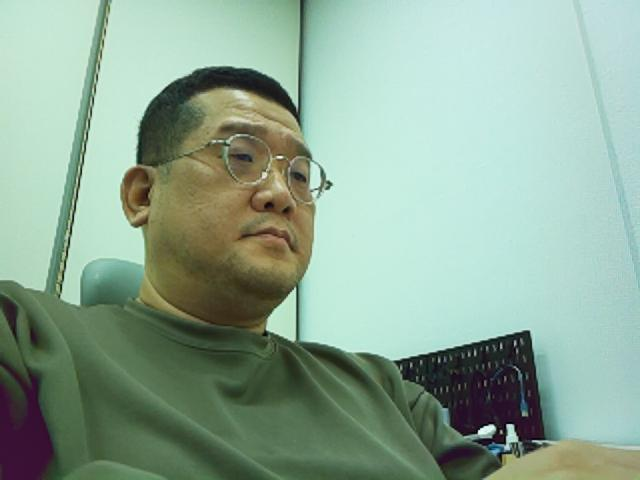

In [42]:
test_camera_once()

In [46]:
import os 
from dotenv import load_dotenv 
from openai import OpenAI  

load_dotenv()

client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

In [47]:
SYSTEM_PROMPT = f"""
You are a helpful robot friend.

Always reply ONLY in JSON:
{{
  "assistant_message": "<reply in Korean>",
  "emotion": "<one of: {', '.join(EMOTIONS)}>"
}}

Infer the user's current emotion.
If unclear, use "basic".
No extra fields, no text outside JSON.
"""

In [48]:
def build_chat_messages(text, hist):
    msgs = [{"role":"system","content":SYSTEM_PROMPT}]
    msgs += hist
    msgs.append({"role":"user","content":text})
    return msgs

In [49]:
def request_chat_emotion(msgs, model="gpt-4.1-mini"):
    res = client.chat.completions.create(
        model=model, messages=msgs, temperature=0.4
    )
    raw = res.choices[0].message.content
    print("RAW:", raw)
    try:
        data = json.loads(raw)
        msg = data.get("assistant_message","")
        emo = data.get("emotion","basic")
    except json.JSONDecodeError:
        msg, emo = raw, "basic"
    if emo not in EMOTIONS: emo = "basic"
    return msg, emo, raw


In [50]:
def chat_with_emotion(text, history=None):
    if history is None: history = []
    msgs = build_chat_messages(text, history)
    reply, emo, raw = request_chat_emotion(msgs)
    history += [{"role":"user","content":text},
                {"role":"assistant","content":raw}]
    return reply, emo, history


In [53]:
history = []
print("대화 시작 (종료: quit/exit/종료)")

while True:
    user = input("You: ")
    if user.lower() in ["quit","exit","종료"]:
        break
    reply, emo, history = chat_with_emotion(user, history)
    print(f"REQ : {user}")
    print(f"Bot({emo}):", reply)
    play_led_emotion(emo)
    play_emotion(emo)
    play_motor_emotion(emo)


대화 시작 (종료: quit/exit/종료)
RAW: {
  "assistant_message": "안녕하세요! 어떻게 도와드릴까요?",
  "emotion": "hello"
}
REQ : 안녕
Bot(hello): 안녕하세요! 어떻게 도와드릴까요?
End Emotion
RAW: {
  "assistant_message": "반가워요! 오늘 기분은 어떠세요?",
  "emotion": "happy"
}
REQ : 방가워
Bot(happy): 반가워요! 오늘 기분은 어떠세요?
End Emotion
RAW: {
  "assistant_message": "주말인데 할 일이 많아서 정말 속상하겠어요. 그래도 조금씩 해나가면 분명히 다 끝낼 수 있을 거예요!",
  "emotion": "sad"
}
REQ : 난 오늘 할일이 많아 너무 슬퍼. 심지어 오늘은 주말이야
Bot(sad): 주말인데 할 일이 많아서 정말 속상하겠어요. 그래도 조금씩 해나가면 분명히 다 끝낼 수 있을 거예요!
End Emotion
RAW: {
  "assistant_message": "고마워요! 언제든지 힘이 되어줄게요. 함께 힘내봐요!",
  "emotion": "happy"
}
REQ : 그래도 니가 있어서 다행이야
Bot(happy): 고마워요! 언제든지 힘이 되어줄게요. 함께 힘내봐요!
End Emotion
RAW: {
  "assistant_message": "편의점이 닫혀 있어서 많이 답답하고 화가 나셨겠어요. 이런 상황 정말 속상하죠.",
  "emotion": "angry"
}
REQ : 이런날 주말이라, 1층 편의점이 문을 열지 않았어, 너무 화가나
Bot(angry): 편의점이 닫혀 있어서 많이 답답하고 화가 나셨겠어요. 이런 상황 정말 속상하죠.
End Emotion
RAW: {
  "assistant_message": "맞아요! 이렇게 생각하면 다이어트에도 도움이 되고 긍정적인 면도 있네요. 좋은 마음가짐이에요!",
  "emotion": "interest"
}
REQ : 

In [54]:
VISION_SYSTEM_PROMPT = f"""
You see a single face image.

Return ONLY JSON:
{{ "emotion": "<one of: {', '.join(EMOTIONS)}>" }}

Choose the best matching emotion from the face.
If unclear, use "basic".
"""


In [55]:
def encode_image_bytes(img_bytes: bytes) -> str:
    return base64.b64encode(img_bytes).decode("utf-8")


In [57]:
def request_vision_raw_response(b64_img, model="gpt-4.1-mini"):
    msg = [
        {"role":"system","content":VISION_SYSTEM_PROMPT},
        {"role":"user","content":[
            {"type":"text","text":"Choose ONE emotion."},
            {"type":"image_url",
                "image_url":{"url":f"data:image/jpeg;base64,{b64_img}"}}
        ]}
    ]
    res = client.chat.completions.create(
        model=model, messages=msg, temperature=0, max_completion_tokens=64
    )
    raw = res.choices[0].message.content
    print("RAW:", raw)
    return raw


In [58]:
def parse_vision_emotion(raw: str) -> str:
    try:
        data = json.loads(raw)
        emo = data.get("emotion","basic").strip()
    except json.JSONDecodeError:
        emo = "basic"
    if emo not in EMOTIONS: emo = "basic"
    return emo


In [59]:
def detect_emotion_from_image_bytes(img_bytes: bytes) -> str:
    b64 = encode_image_bytes(img_bytes)
    raw = request_vision_raw_response(b64)
    return parse_vision_emotion(raw)


In [60]:
def capture_image(cam):
    img_bytes = capture_one_frame_bytes(cam)
    display(Image.open(io.BytesIO(img_bytes)))
    return img_bytes

def process_emotion(img_bytes):
    emo = detect_emotion_from_image_bytes(img_bytes)
    print("Detected emotion:", emo)
    return emo


In [61]:
def run_camera_emotion_once():
    cam = Camera(); cam.start()
    img_bytes = capture_image(cam)
    emo = process_emotion(img_bytes)
    play_led_emotion(emo)
    play_emotion(emo)
    play_motor_emotion(emo)
    cam.close()


[4:20:32.273080873] [19462]  INFO Camera camera_manager.cpp:325 libcamera v0.3.2+99-1230f78d
[4:20:32.294085250] [21096]  INFO RPI pisp.cpp:695 libpisp version v1.0.7 28196ed6edcf 28-11-2024 (14:00:13)
[4:20:32.304176967] [21096]  INFO RPI pisp.cpp:1154 Registered camera /base/axi/pcie@120000/rp1/i2c@80000/ov5647@36 to CFE device /dev/media0 and ISP device /dev/media1 using PiSP variant BCM2712_D0
[4:20:32.307365237] [19462]  WARN V4L2 v4l2_pixelformat.cpp:346 Unsupported V4L2 pixel format RPBP
[4:20:32.307890921] [19462]  INFO Camera camera.cpp:1197 configuring streams: (0) 640x480-RGB888 (1) 640x480-GBRG_PISP_COMP1
[4:20:32.308030143] [21096]  INFO RPI pisp.cpp:1450 Sensor: /base/axi/pcie@120000/rp1/i2c@80000/ov5647@36 - Selected sensor format: 640x480-SGBRG10_1X10 - Selected CFE format: 640x480-PC1g


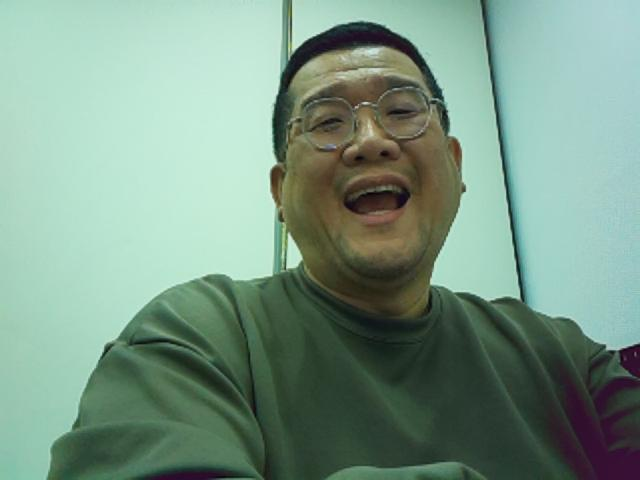

RAW: { "emotion": "happy" }
Detected emotion: happy
End Emotion


In [62]:
run_camera_emotion_once()